In [1]:
# import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Data Preprocessing 
- Loading and splitting data
- Train: 80%, and Validation: 20%

In [2]:
# Define constants
data_dir = '/kaggle/input/potato-diseases/data'
batch_size = 32
img_h = 128
img_w = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_h,  img_w),
    batch_size = batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
    validation_split = 0.2,
    subset ='validation', 
    seed = 123,
    image_size = (img_h, img_w),
    batch_size = batch_size
)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.


EDA

In [3]:
def plot_ditribution(y, title):
    a = Counter(y)
    y = ['Early_blight', 'Healty', 'Late_blight']
    x = [a[i] for i in range(3)]
    plt.figure(figsize = (8,3))
    plt.barh(y,x, color='yellow')
    plt.title(title)
    return plt.show()

In [4]:
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val= np.concatenate([y for x, y in val_ds], axis=0)

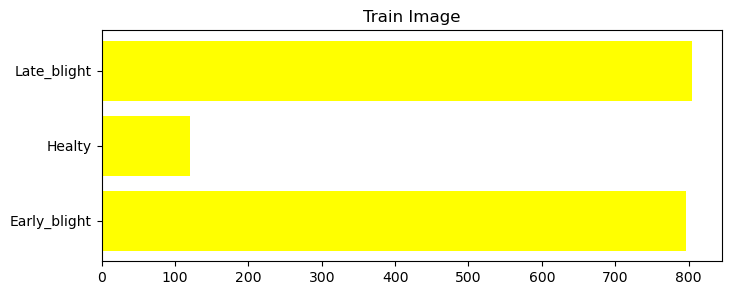

In [5]:
plot_ditribution(y_train, title='Train Image')

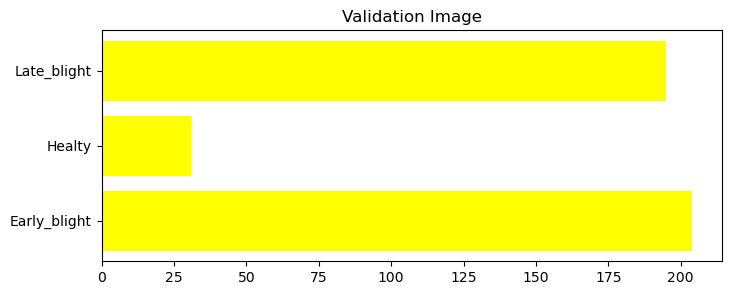

In [6]:
plot_ditribution(y_val, title='Validation Image')

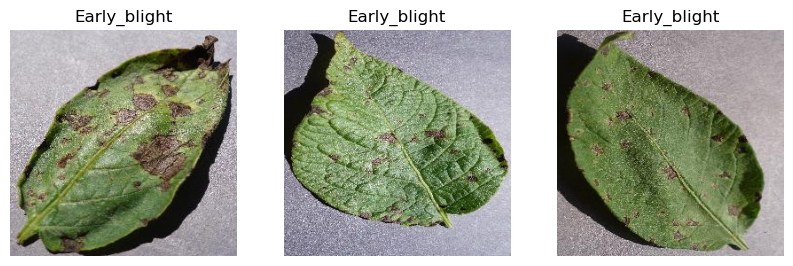

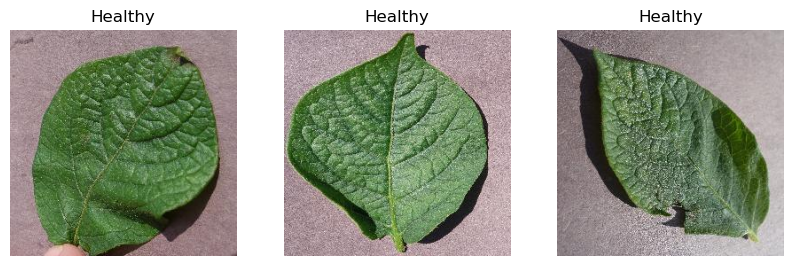

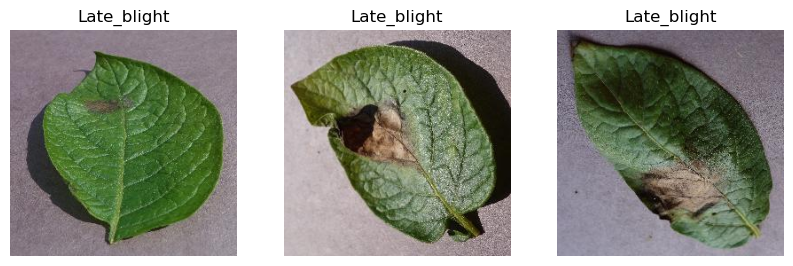

In [7]:
# Let see the image we have from the train ds
class_name = train_ds.class_names
for class_name in class_name:
    imgs = os.listdir(os.path.join(data_dir,class_name))[:3]
    plt.figure(figsize=(10,10))
    for i, img in enumerate(imgs):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(os.path.join(data_dir, class_name, img)))
        plt.title(class_name)
        plt.axis('off')

In [8]:
# Model Training
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_h, img_w, 3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(3, activation='softmax')
])

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=5)

In [12]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=[earlystop_callback])

Epoch 1/20
54/54 [==============================] - 17s 293ms/step - loss: 0.7408 - accuracy: 0.6580 - val_loss: 0.4227 - val_accuracy: 0.8349
Epoch 2/20
54/54 [==============================] - 14s 267ms/step - loss: 0.3821 - accuracy: 0.8595 - val_loss: 0.2948 - val_accuracy: 0.9070
Epoch 3/20
54/54 [==============================] - 15s 274ms/step - loss: 0.2796 - accuracy: 0.8914 - val_loss: 0.2718 - val_accuracy: 0.9140
Epoch 4/20
54/54 [==============================] - 14s 266ms/step - loss: 0.2381 - accuracy: 0.9053 - val_loss: 0.1955 - val_accuracy: 0.9349
Epoch 5/20
54/54 [==============================] - 15s 270ms/step - loss: 0.1718 - accuracy: 0.9355 - val_loss: 0.2514 - val_accuracy: 0.9000
Epoch 6/20
54/54 [==============================] - 15s 275ms/step - loss: 0.1375 - accuracy: 0.9501 - val_loss: 0.1675 - val_accuracy: 0.9488
Epoch 7/20
54/54 [==============================] - 14s 267ms/step - loss: 0.0958 - accuracy: 0.9686 - val_loss: 0.1703 - val_accuracy: 0.9349

In [13]:
#
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

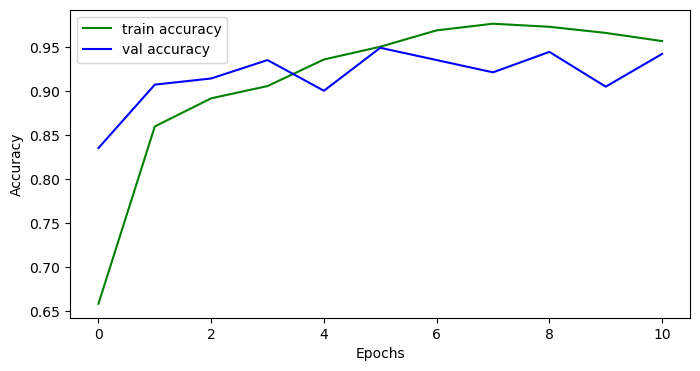

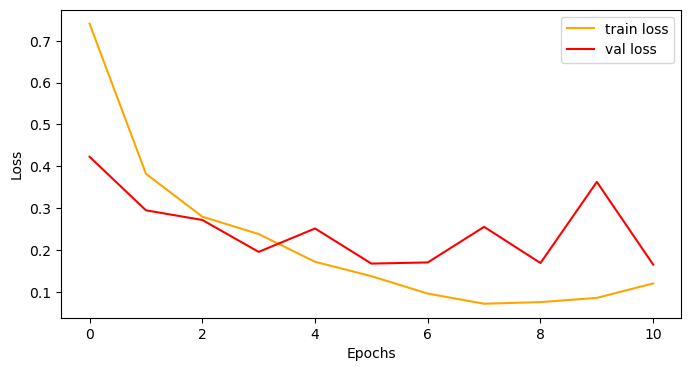

In [14]:
# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss plots
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
loss, acc = model.evaluate(val_ds, batch_size=batch_size)
print("validation accuracy :", round(acc, 2))
print("validation loss :", round(loss,2))

14/14 [==============================] - 1s 61ms/step - loss: 0.1649 - accuracy: 0.9419
validation accuracy : 0.94
validation loss : 0.16


In [16]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 121ms/step


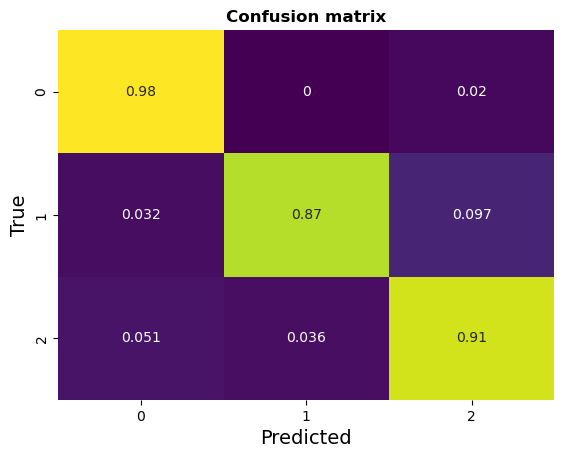

In [17]:
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

In [18]:
print(classification_report(correct_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.95      0.98      0.96       204
           1       0.79      0.87      0.83        31
           2       0.96      0.91      0.94       195

    accuracy                           0.94       430
   macro avg       0.90      0.92      0.91       430
weighted avg       0.94      0.94      0.94       430



In [19]:
def prediction(img):
    class_names = ['Early_blight', 'Healthy', 'Late_blight']

    my_image = load_img(img, target_size=(img_h, img_w))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0)

    out = np.round(model.predict(my_image)[0], 2)
    fig = plt.figure(figsize=(7, 4))
    plt.barh(class_names, out, color='lightgray',edgecolor='red', linewidth=1, height=0.5)

    for index, value in enumerate(out):
        plt.text(value/2 + 0.1, index, f"{100*value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks([0, 1, 2], labels=class_names, fontweight='bold', fontsize=14)
    fig.savefig('pred_img.png', bbox_inches='tight')
    return plt.show()

1/1 [==============================] - 0s 27ms/step


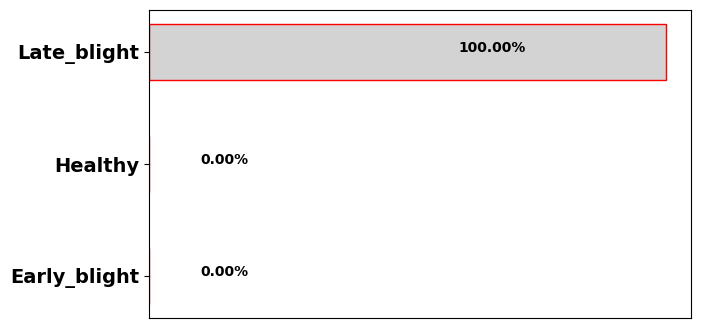

In [20]:
img = '/kaggle/input/potato-diseases/data/Late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG'
prediction(img)